# 6. Interactions between blobs case study

This notebook will go over a simulation in which blobs are allowed to interact with each other. This more closely resembles the real-world, where organisms co-evolve with other organisms in their vicinity

In [1]:
import sys
sys.path.append('..')
from environment import *
from blobs import *
from helpers import *

%load_ext autoreload
%autoreload 2

## 6.1 New blob types

To start off, let's introduce three new kinds of blobs that contain interactive mechanisms. All of these inherit from the `BaseInteractingBlob` class which contains an additional `interact_with_surroundings` method:
1. `AttackingBlob`: this blob will attack other blobs within its immediate vicinity
2. `TimidBlob`: this blob will run away from any other blobs
3. `QuickBlob`: this blob is faster than other blobs and wil reach food before other blobs do

Each of these blobs will have the same `(s, r, m)` probabilities so that we can compare purely the different survival strategies. The simulation will be setup in an environment that can accomodate these interactions. We have setup this environment in `InteractiveEnvironment`, which inherits from `EnvironmentWithFood`. As such, each blob will be moving towards and competing for food at each epoch, with the blobs that get the food guaranteed survival

To begin, let's examine how each of these new blobs do in a vacuum compared to `HungryBlob`s

The differences between the three new blobs are:
1) The `AttackingBlob`'s survival strategy is to attack any blobs within a radius of `self.size`. The damage afflicted on blobs at the other end of the attack is reflected as 

    `survival_prob -= AttackingBlob.attack_dmg`
    
2) `TimidBlob`'s survival strategy is to run away from any nearby blobs

3) `QuickBlob`'s survival strategy is to arrive at the food quicker than other blobs. As a result, it has a faster claim to the food.

With each strategy, there's a suspected consequence based on our priors of studying priors in nature. It is reasonable that:
1) `AttackingBlob`s will cull out the competition over time as more and more interactions weaken the competition
2) `TimidBlob`'s will die out over time as the nature of their interaction means that they move away from food 
3) `QuickBlob`s will survive fairly well as their survival depends on their ability to outcompete other blobs in the race to food

Let's setup these simulations to see how accurate our priors are

In [2]:
n_each_blob = 5
n_food_spawned = 10
n_epochs = 20

First, let's look at how `HungryBlob`s will do in a vacuum. We'll make these HungryBlobs non-mutable so as to only examine the base effects

In [3]:
class HungryBlobNM(HungryBlob):
    """Non-mutating HungryBlob"""
    def __init__(self) -> None:
        super().__init__()
        self.name = 'HungryBlobsNM'
        self.mutation_prob = 0.0
        self.mutation_class = HungryBlobNM
        self.repr_class = HungryBlobNM

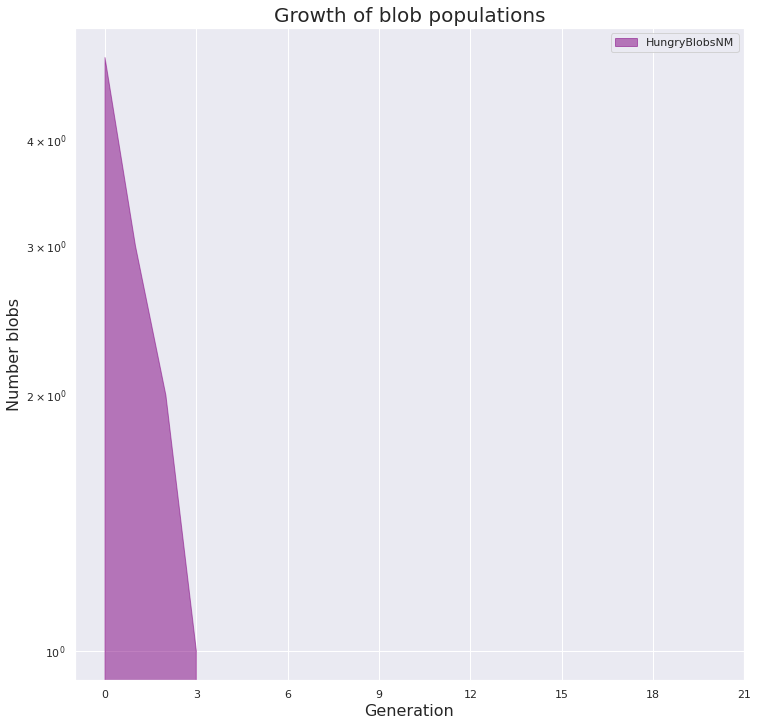

In [4]:
hungry_pop = [HungryBlobNM() for p in range(n_each_blob)]

e = InteractiveEnvironment(food=n_food_spawned)
e.spawn_population(hungry_pop)
for i in range(n_epochs):
    e.interact()
e.plot_growth()

As a whole, the population is stable enough that it should continue to grow if no outside influence exists

Now let's simulate adding equivalent amounts of the new blob types and see how that impacts the long-term survival of the `HungryBlobNM`s

In [5]:
hungry_pop = [HungryBlobNM() for p in range(n_each_blob)]

attacking_pop = [AttackingBlob() for a in range(n_each_blob)]

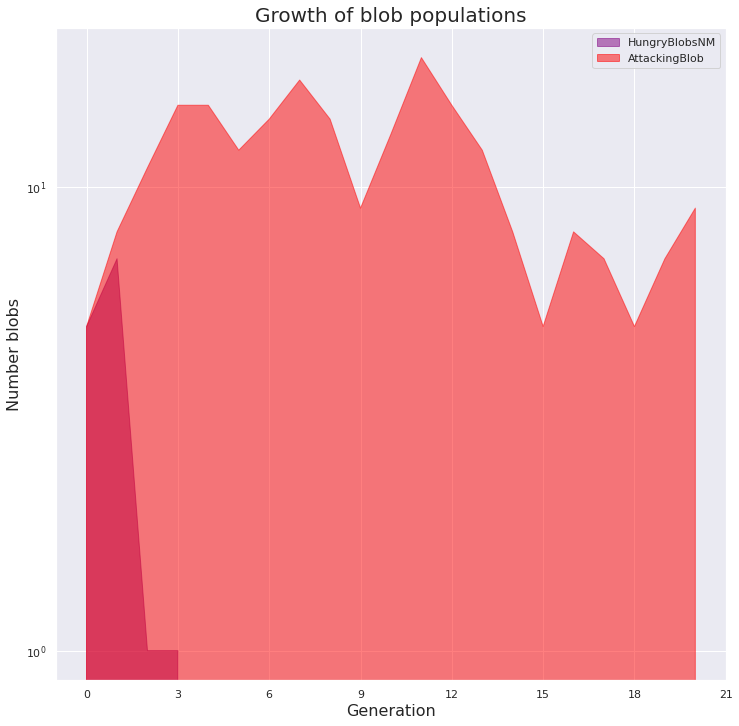

In [6]:
e = InteractiveEnvironment(food=n_food_spawned)
e.spawn_population(hungry_pop + attacking_pop)
for i in range(n_epochs):
    e.interact()
e.plot_growth()

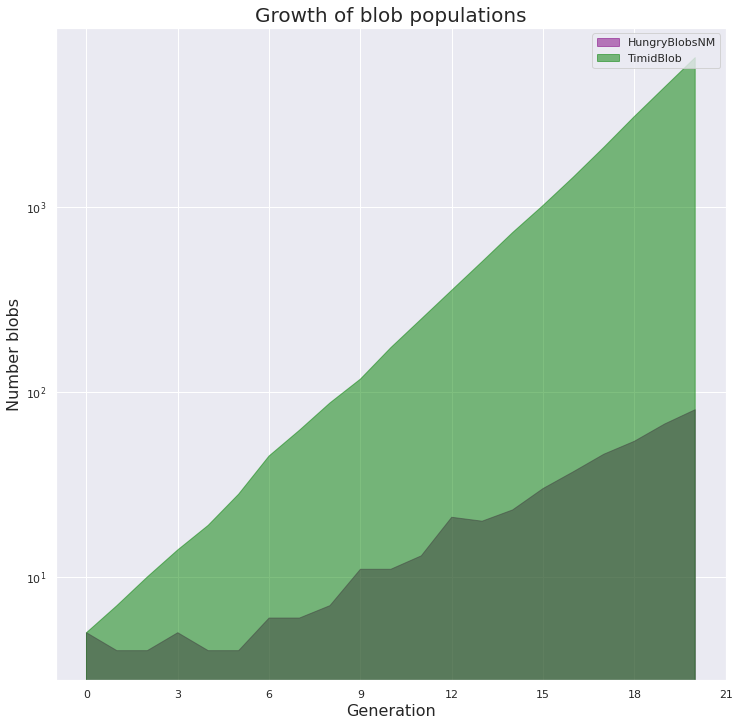

In [7]:
hungry_pop = [HungryBlobNM() for p in range(n_each_blob)]

timid_pop = [TimidBlob() for a in range(n_each_blob)]

e = InteractiveEnvironment(food=n_food_spawned)
e.spawn_population(hungry_pop + timid_pop)
for i in range(n_epochs):
    e.interact()
e.plot_growth()

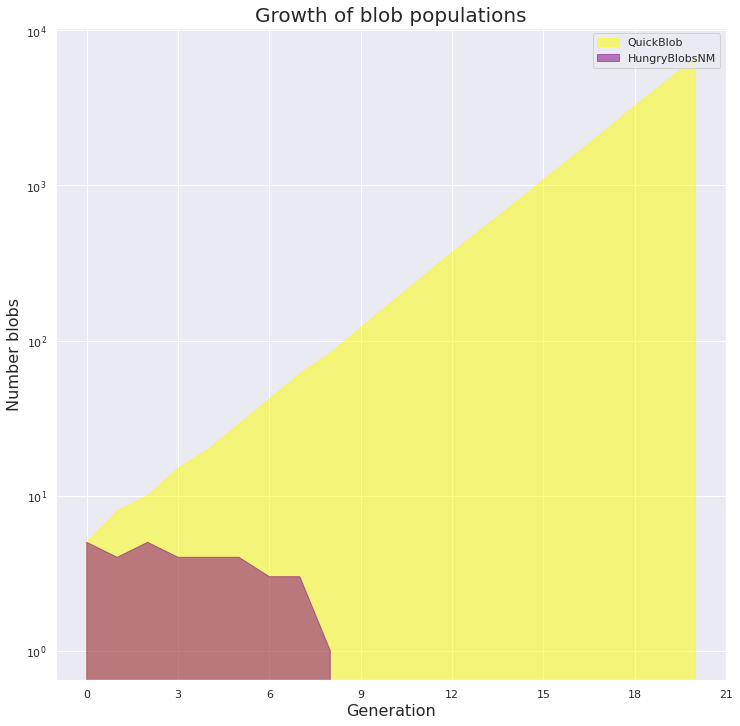

In [8]:
hungry_pop = [HungryBlobNM() for p in range(n_each_blob)]

quick_pop = [QuickBlob() for a in range(n_each_blob)]

e = InteractiveEnvironment(food=n_food_spawned)
e.spawn_population(hungry_pop + quick_pop)
for i in range(n_epochs):
    e.interact()
e.plot_growth()

What we see in these simulations is consistent with our priors.

1. In the `AttackingBlob` simulation, the population of other blobs was wiped out due to aggression and damage inflicted by the `AttackingBlob`s
2. In the `TimidBlob` simulation, the population of `TimidBlob`s grew alongside other blobs as it does nothing to interfere with the other blobs. All blobs have an equal claim to the food based off luck
3. In the `QuickBlob` simulation, the other blobs quickly died out as the `QuickBlob`s were able to reach and consume the food before the other blobs

## 6.2 Interactions between new blobs

Now let's examine how these blobs interact together. We'll start off by analyzing one simulation before setting up a monte carlo similar to in <b>4.1</b> so that we can extrapolate to the overall emergent behaviors

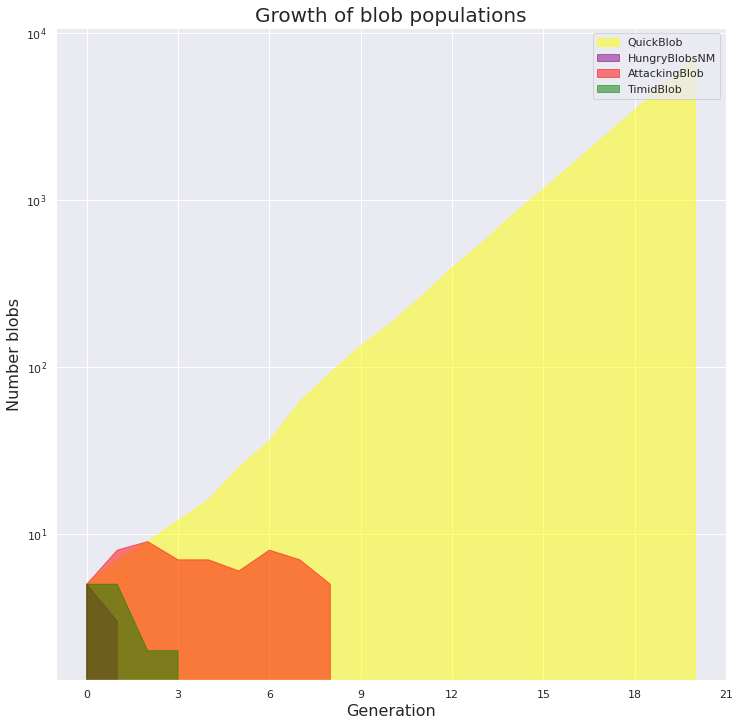

In [9]:
hungry_pop = [HungryBlobNM() for p in range(n_each_blob)]
attacking_pop = [AttackingBlob() for a in range(n_each_blob)]
timid_pop = [TimidBlob() for a in range(n_each_blob)]
quick_pop = [QuickBlob() for a in range(n_each_blob)]

e = InteractiveEnvironment(food=n_food_spawned)
e.spawn_population(hungry_pop + attacking_pop + timid_pop + quick_pop)
for i in range(n_epochs):
    e.interact()
e.plot_growth()

Wow! In this simulation, the `QuickBlob`s quickly outgrew the rest of the blob types. It appears that being able to reach food first is a huge evolutionary advantage. Let's see how big of an advantage it is via. monte carlo. We'll define success as whichever blob has the highest count at `n_epochs`. This is built into `pyevo` via the `determine_most_prevalent_blob` method

In [10]:
#Setup conditions of the simulation
n_starting_blobs = 10
n_epochs = 20
n_simulations = 1000

In [11]:
winners = []
for n in range(n_simulations):
    attacking_pop = [AttackingBlob() for a in range(n_starting_blobs)]
    timid_pop = [TimidBlob() for a in range(n_starting_blobs)]
    quick_pop = [QuickBlob() for a in range(n_starting_blobs)]
    
    e = BaseEnvironment()
    e.spawn_population(attacking_pop + timid_pop + quick_pop)
    for epoch in range(n_epochs):
        e.interact()
    winners.append(determine_most_prevalent_blob(e.population))

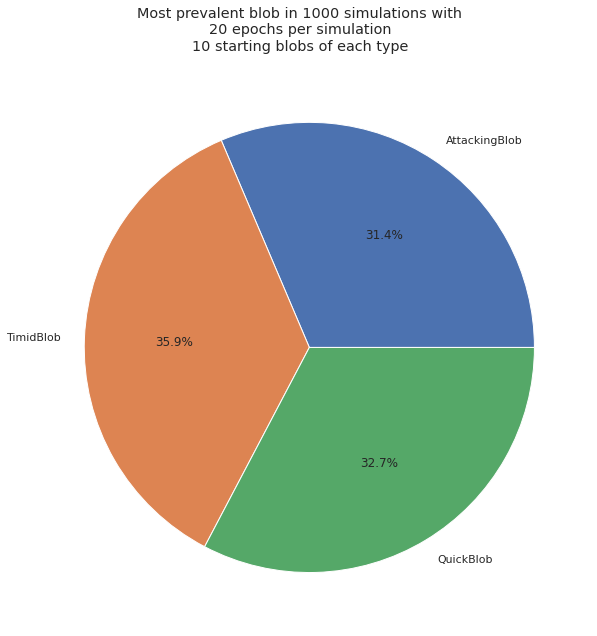

In [12]:
fig, ax = plt.subplots(figsize=(9,9))
ax.pie([winners.count('AttackingBlob'), winners.count('TimidBlob'), winners.count('QuickBlob')],
       labels=['AttackingBlob', 'TimidBlob', 'QuickBlob'],
    autopct='%1.1f%%')

fig.suptitle(f'Most prevalent blob in {n_simulations} simulations with\n'
             f'{n_epochs} epochs per simulation\n'
             f'{n_starting_blobs} starting blobs of each type')
plt.tight_layout()
plt.show()

Interesting! Counter to what we expected, it seems like over the course of many simulations, each type of reproductive strategy wins out roughly 1/3 of the time. This is a good example as to why extrapolating from one example is a bad idea, as if we simply did that from the first simulation, we would've falsely assumed that being quick was the most useful attribute

Next, let's vary the attributes of each blob type. In particular, let's examine the effect of a higher attack damage for the `AttackBlob`s